## How lime work 

1. Permute data*
2. Calculate disrance between permutations and original observations*
3. Make predictions on new data using complex model
4. Pick m features best describing the complex model outcome from permuted data *
5. Fit a simple model to the permuted data with m features and similarity scores as weights*
6. Features weight from simple model make explainations for the complex models local behaviour

In [3]:
# Part 1 - Building the CNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import model_from_json
from io import StringIO
import os

In [1]:
from PIL import Image,ImageFile
import warnings #To handle Warning
warnings.filterwarnings("ignore")

ImageFile.LOAD_TRUNCATED_IMAGES = True
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator


fpath = "D:\GITHUB\Lime-Explaining-Mask-Image\Face-Mask-Dataset\Train"
cate = os.listdir(fpath)
print("List of categories = ",cate,"\n\nNo. of categories = ", len(cate))
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'D:\GITHUB\Lime-Explaining-Mask-Image\Face-Mask-Dataset\Train',  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        batch_size=batch_size,

        # Specify the classes explicitly
        
       
        classes =  cate,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

test_set = train_datagen.flow_from_directory('D:\GITHUB\Lime-Explaining-Mask-Image\Face-Mask-Dataset\Test',
                                            target_size = (200, 200),
                                            batch_size = batch_size,
                                            classes=cate,
                                            class_mode = 'categorical')
val_set = train_datagen.flow_from_directory('D:\GITHUB\Lime-Explaining-Mask-Image\Face-Mask-Dataset\Validation',
                                            target_size = (200, 200),
                                            batch_size = batch_size,
                                            classes=cate,
                                            class_mode = 'categorical')


List of categories =  ['WithMask', 'WithoutMask'] 

No. of categories =  2
Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Design model

In [5]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 2 output neurons for 2 classes with the softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

## Fit model

In [6]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

total_sample=train_generator.n

n_epochs = 30

In [7]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
history = model.fit(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=n_epochs,
        validation_data=val_set,
        verbose=1)

Epoch 1/30
312/312 [==============================] - 333s 1s/step - loss: 0.3843 - acc: 0.8176 - val_loss: 0.0533 - val_acc: 0.9787
Epoch 2/30
312/312 [==============================] - 181s 581ms/step - loss: 0.0709 - acc: 0.9747 - val_loss: 0.0515 - val_acc: 0.9850
Epoch 3/30
312/312 [==============================] - 183s 586ms/step - loss: 0.0519 - acc: 0.9826 - val_loss: 0.0288 - val_acc: 0.9887
Epoch 4/30
312/312 [==============================] - 184s 588ms/step - loss: 0.0432 - acc: 0.9869 - val_loss: 0.0193 - val_acc: 0.9925
Epoch 5/30
312/312 [==============================] - 181s 581ms/step - loss: 0.0364 - acc: 0.9887 - val_loss: 0.0306 - val_acc: 0.9925
Epoch 6/30
312/312 [==============================] - 181s 580ms/step - loss: 0.0361 - acc: 0.9909 - val_loss: 0.0300 - val_acc: 0.9912
Epoch 7/30
312/312 [==============================] - 181s 581ms/step - loss: 0.0350 - acc: 0.9901 - val_loss: 0.0154 - val_acc: 0.9925
Epoch 8/30
312/312 [==============================]

## Visualization 

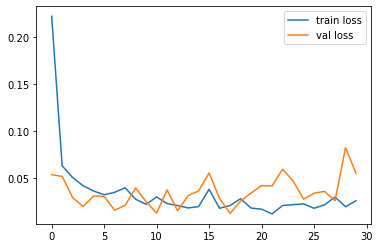

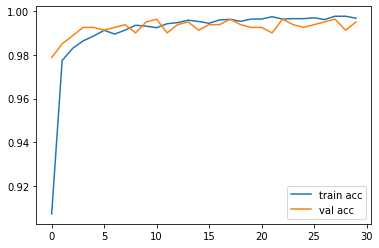

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [9]:
loss, accuracy = model.evaluate(test_set)
print('Test accuracy:' , accuracy * 100,'%')

31/31 [==============================] - 18s 604ms/step - loss: 0.1243 - acc: 0.9869
Test accuracy: 98.68951439857483 %


## Save model

In [ ]:
model.save('CNN_model.h5')

In [1]:
from keras.models import load_model
import pandas as pd
import numpy as np
import skimage
import skimage.transform
from tensorflow.keras.preprocessing import image
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
import cv2
model_cnn= load_model("D:\GITHUB\Lime-Explaining-Mask-Image\CNN_model.h5")
face_cascade =cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

without_mask
100.0


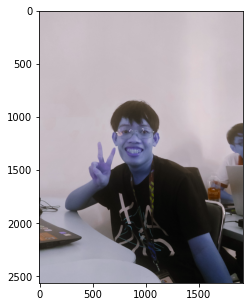

In [4]:
test_image = cv2.imread('./Image-Result/pj_mam.jpg')
k=test_image
test_image =cv2.resize(test_image,(200,200))
#test_image =test_image.resize((200,200),Image.ANTIALIAS)
test_image = np.expand_dims(test_image, axis=0)
result = model_cnn.predict(test_image)
labels_dict={0:'without_mask',1:'with_mask'}
if result[0][0] > result[0][1]:
    percent = round(result[0][0]*100,2)
    label=np.argmax(result,axis=1)[0]
else:
    percent = round(result[0][1]*100,2) 
    label=np.argmax(result,axis=1)[1]
print(labels_dict[label])
print(percent)
fig, ax = plt.subplots( figsize=(5,5))
ax.imshow(k)



In [142]:
from keras.models import load_model
import pandas as pd
import numpy as np
import skimage
import skimage.transform
from tensorflow.keras.preprocessing import image
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image
import cv2
model_cnn= load_model("D:\GITHUB\Lime-Explaining-Mask-Image\CNN_model.h5")
 
# The function cv2.imread() is used to read an image.
im = cv2.imread('./Image-Result/pj_mam_1.jpg')
resized= cv2.resize(im,(200,200))
normalized=resized/255.0
reshaped=np.reshape(normalized,(1,200,200,3))
reshaped = np.vstack([reshaped])

labels_dict={1:'without_mask',0:'with_mask'}

# The function cv2.imshow() is used to display an image in a window.

result=model_cnn(reshaped)
if (result[0][0]>result[0][1]):
    label=1
else:
    label=0
print(labels_dict[label])

cv2.imshow('graycsale image',im)
# waitKey() waits for a key press to close the window and 0 specifies indefinite loop
cv2.waitKey(0)
 
# cv2.destroyAllWindows() simply destroys all the windows we created.
cv2.destroyAllWindows()

without_mask


In [143]:
im[0].shape

(591, 3)

## Test Image downloading from gg

f:\APP_TECH\Python\lib\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


[[1.000000e+00 4.389064e-12]]
It's face with mask!


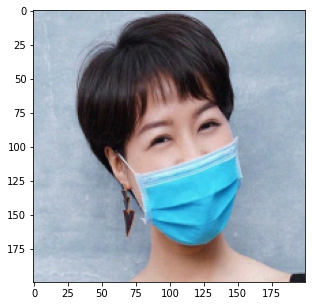

In [386]:
import numpy as np
import pandas as pd
import skimage
import skimage.transform
from tensorflow.keras.preprocessing import image
from skimage import io
test_image_dir='./Image-Result/test5.jpg'
images = skimage.io.imread(test_image_dir)
images = skimage.transform.resize(images, (200,200))
images = image.img_to_array(images)
images = np.expand_dims(images, axis=0)
# Predict the probabilities for both the classes
preds = model_cnn.predict_proba(images)
print(preds)
predicted_class_prob = np.max(preds)

# Plot the image for which we want to predict the class
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(images[0])


# Predict the class which is predicted with highest probability by the model
if preds[0][0]>preds[0][1]:
    print('It\'s face with mask!')
else:
    print('It\'s a face without mask!')


In [387]:
images[0].shape


(200, 200, 3)

In [388]:
from lime.wrappers import scikit_image

In [389]:
# segmentation using quickshift algorithm
segmentation_fn = scikit_image.SegmentationAlgorithm('quickshift', kernel_size=3,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=12)
segments = segmentation_fn(images[0])

In [390]:
segments.shape

(200, 200)

In [391]:
# Numbers of superpixels or features of the image
len(np.unique(segments))

48

Superpixels of the image


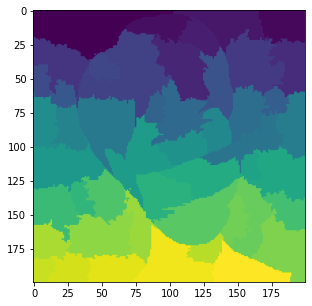

In [392]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow(segments)
print('Superpixels of the image')

In [393]:
from sklearn.utils import check_random_state
import copy
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

In [394]:
# hide_color=0 means we want superpixels of this color will be hidden while creating purturbed samples
hide_color=0

In [395]:
# Creating the fudged_image: a 3-D numpy array(image) to replace original image when superpixel is turned off

fudged_image = images[0].copy()

# If hide_color is not None superpixels of hide_color(here 0) will be used to create fudged_image, otherwise mean pixel color will be used

if hide_color is None:
    for x in np.unique(segments):
        fudged_image[segments == x] = (
            np.mean(images[0][segments == x][:, 0]),
            np.mean(images[0][segments == x][:, 1]),
            np.mean(images[0][segments == x][:, 2]))
else:
    fudged_image[:] = hide_color

In [396]:
print(fudged_image.shape)

(200, 200, 3)


In [397]:
# Creating the perturbed samples and predicting their class y using the CNN model
# btach_size=32 means classifier function will be called in a batch size of 32 to predict the labels for the perturbed samples
data,labels=explainer.data_labels(images[0], fudged_image, segments,
                                        classifier_fn=model_cnn.predict, num_samples=1000,
                                        batch_size=32
                                        )

  0%|          | 0/1000 [00:00<?, ?it/s]

In [398]:
# Example of a perturbed sample
data[1]

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1])

In [399]:
# shape of a pertubed sample
print(data[1].shape)

(48,)


In [400]:
### How perturbed images will look like???

def perturbed_images_generation(image,fudged_image,segments,data):
    rows = data
    imgs = []
    req_images=[]
    # Iterate through each of the row of the array called data
    for row in rows:
        # temp a copy of the original image
        temp = copy.deepcopy(images[0])
        # Finding the indexes of the zeros in each row
        zeros = np.where(row == 0)[0]
        # create an temporary array called mask same shape as of segments(here (256,256)) which contains all the values as False
        mask = np.zeros(segments.shape).astype(bool)
        # For each zero(off superpixel) in each row of data replace the image by the fudged_image 
        for z in zeros:
            mask[segments == z] = True
        temp[mask] = fudged_image[mask]
        imgs.append(temp)
        req_images.extend(imgs)
        imgs = []
            
    return req_images

In [401]:
# Perturbed images
perturbed_images=perturbed_images_generation(images[0],fudged_image,segments,data)

In [402]:
# Calculate the distances between perturbed images and original image
import sklearn
distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric='cosine'
        ).ravel()

In [403]:
# Find the top 3 closest perturbed images
df=pd.DataFrame(distances,columns=['distance'])
df1=df.sort_values(by='distance')
df1=df1.drop_duplicates(keep='first')
req_index=df1.index[1:4]
req_index

Int64Index([255, 880, 419], dtype='int64')

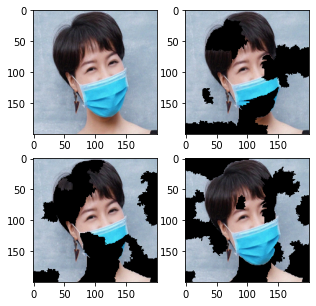

In [404]:
# Plotting the original and top 3 closest perturbed images
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(5,5))
ax1.imshow(perturbed_images[0])
ax2.imshow(perturbed_images[req_index[0]])
ax3.imshow(perturbed_images[req_index[1]])
ax4.imshow(perturbed_images[req_index[2]])

In [405]:
# for LIME
from lime.lime_base import LimeBase
from sklearn.linear_model import Ridge, lars_path
from functools import partial
import scipy as sp
from sklearn.utils import check_random_state

In [406]:
# Exponential kernel
def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

In [407]:
# exponential kernel with kernel width 25
kernel_fn = partial(kernel, kernel_width=25)

In [408]:
# Samples are given weights using exponential kernel
weights=kernel_fn(distances)

In [409]:
from sklearn.linear_model import Ridge

In [410]:
# We want the explanation for 'without_mask' class
labels_column = labels[:, 0]#1

In [411]:
# we want top 10 features in our explanation
# Ridge regression is fitted on the local data
clf = Ridge(alpha=0.01, fit_intercept=True)
clf.fit(data, labels_column, sample_weight=weights)
coef = clf.coef_

In [412]:
labels

array([[1.0000000e+00, 4.3890642e-12],
       [1.0000000e+00, 2.0390390e-30],
       [1.0000000e+00, 6.5599050e-18],
       ...,
       [1.0000000e+00, 3.1725417e-23],
       [1.0000000e+00, 1.8269416e-20],
       [1.0000000e+00, 1.3500493e-21]], dtype=float32)

In [413]:
coef

array([ 1.43179814e-05,  4.48623988e-05, -4.67374453e-05, -4.53794124e-05,
       -4.14042623e-05, -4.70941892e-05,  5.95523491e-05,  4.75644060e-05,
        3.49146982e-05, -4.37749281e-05, -4.07556314e-05,  3.74197798e-05,
        3.82884429e-05, -4.48172055e-05, -3.56574561e-05, -4.36001843e-05,
        4.28482490e-05,  4.42641878e-05,  5.34921465e-05, -5.34388796e-05,
       -3.58571305e-05,  5.28042766e-05,  3.73519839e-05,  5.10659606e-05,
        4.50601219e-05,  4.49182124e-05, -4.49624408e-05,  3.51510784e-05,
        4.08533005e-05,  3.22271107e-05, -3.44364736e-05,  3.79872179e-05,
        3.72356410e-05, -4.12564374e-05,  6.55908134e-05,  3.90001417e-05,
        2.21721606e-05,  4.56017005e-05,  3.19362696e-05,  5.23695835e-05,
       -3.66350865e-05,  3.52456779e-05, -4.71793204e-05,  3.98753414e-05,
        4.63769594e-05,  3.76067655e-05, -5.36490859e-05, -4.01860207e-05])

In [414]:
## The top 10 features or superpixels 
num_features = 10
top_features = np.argsort(np.abs(coef))[-num_features:] 
top_features

array([42,  7, 23, 39, 21, 19, 18, 46,  6, 34], dtype=int64)

In [415]:
# After getting the features Ridge regression is used to fit the local model 

model_regressor = Ridge(alpha=0.01, fit_intercept=True)
                                
easy_model = model_regressor
easy_model.fit(data[:, top_features],
               labels_column, sample_weight=weights)
prediction_score = easy_model.score(
    data[:, top_features],
    labels_column, sample_weight=weights)

local_pred = easy_model.predict(data[0, top_features].reshape(1, -1))


In [416]:
local_pred

array([1.00006467])

In [417]:
# import the necessary packages
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

In [418]:
# top_labels=2 means we want the explanation for 2 levels
# hide_color=0 means superpixels of this color will be hidden while creating perturbed samples
# num_samples=1000 means a total 1000 perturbed samples will be created in the neighbourhood of an image
explanation = explainer.explain_instance(images[0], model_cnn.predict,  
                                         top_labels=2,hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

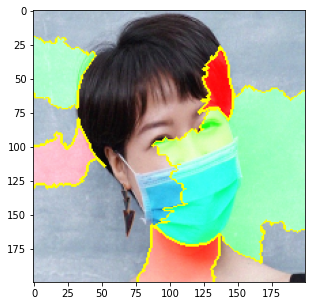

In [419]:
# We want to see the superpixels that are affecting postively and negatively in the prediction 
# we want to see top 10 superpixels in the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,negative_only=False, num_features=10, hide_rest=False)

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(mark_boundaries(temp, mask))
